In [1]:
import time
import cv2
import polanalyser as pa
from PIL import Image
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import numpy as np
import os
import sys
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from scipy import ndimage

%matplotlib notebook
import importlib
pyfilepath = '..//controller.py'
dirname, basename = os.path.split(pyfilepath) 
sys.path.append(dirname) 
module_name = 'controller'
controller = importlib.import_module(module_name) 

In [2]:
imager = controller.Imager()
num_cams = len(imager.cams)

Found 1 devices
Devices IDs - ['101936']


In [3]:
exposure=3000 # set exposure time in micro-seconds

imager.cams[-1].remote_device.node_map.ExposureAuto.value = 'Off'
PIXELFORMATS = {'8':'Mono8','12':'Mono12Packed'}

PIXELFORMAT = PIXELFORMATS['8']  # set pixel format
imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)
imager._start_acquisitions()
time.sleep(1)

In [117]:
num_images = 100
break_sets = 0.1 #in seconds
break_images = 0 # if == 0: 3 images are taken with no break (for repetition),
                         # then then there is a break_sets.
                         # if break_sets == break_images,
                         # there is no repetition.

In [141]:
def create_circle(H,W,center_y,center_x,radius= 5):
    x = np.linspace(0,W,W, endpoint=False)
    y = np.linspace(0,H,H, endpoint=False)
    X, Y = np.meshgrid(x, y)
    A = (X - center_x)**2 + (Y - center_y)**2
    circle = A <= radius**2
    return circle

def get_IS_port_circle_roi(original_image, margine = 10):
    """
    with the arguments:
    gray: Input image (grayscale).
    circles: A vector that stores sets of 3 values: xc,yc,r for each detected circle.
    HOUGH_GRADIENT: Define the detection method. Currently this is the only one available in OpenCV.
    dp = 1: The inverse ratio of resolution.
    min_dist = gray.rows/16: Minimum distance between detected centers.
    param_1 = 200: Upper threshold for the internal Canny edge detector.
    param_2 = 100*: Threshold for center detection.
    min_radius = 0: Minimum radius to be detected. If unknown, put zero as default.
    max_radius = 0: Maximum radius to be detected. If unknown, put zero as default.
    """
    VISUALIZE = False
    img_gray = np.uint8(original_image).copy()
    img_gray = cv2.medianBlur(img_gray, 5)
    rows = img_gray.shape[0]
    
    circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
    
    if circle is None:
        img_gray = img_gray/np.max(img_gray)
        img_gray = np.uint8(255*img_gray)
        circle = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 500)
        
    print(circle)
    # convert the (x, y) coordinates and radius of the circles to integers
    circle = np.round(circle[0, :]).astype("int")
    # draw the circle in the output image, then draw a rectangle
    # corresponding to the center of the circle
    if VISUALIZE:
        cv2.namedWindow('Image', cv2.WINDOW_NORMAL)

    x, y, r = circle[0]
    # Center coordinates
    center_coordinates = (x,y)
    # Radius of circle
    radius = r
    radius_margine = r + margine
    # Blue color in BGR
    color = (0, 0, 255)
    # Line thickness of 2 px
    thickness = 10
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 2 px
    # covert to RGB image just for circle visualization:
    img_rgb = np.dstack((img_gray,img_gray,img_gray))
    image = cv2.circle(img_rgb, center_coordinates, radius, color, thickness)
    roi = [int(x-radius_margine),int(y-radius_margine),int(x+radius_margine),int(y+radius_margine)]
    img_gray = img_gray[int(y-radius_margine):int(y+radius_margine), int(x-radius_margine):int(x+radius_margine)]
    x = x - int(x-radius_margine)
    y = y - int(y-radius_margine)
    
    if VISUALIZE:
        cv2.imshow('Image',image)
        cv2.waitKey(0)
        cv2.destroyWindow('Image') 
    
    return img_gray, roi, x, y, r # use roi as: IMG[roi[1]:roi[3],roi[0]:roi[2]]



def clear_circle_edges(original_image, margine = 30):
    img_gray = original_image.copy()
    output = np.zeros_like(img_gray)
    croped_image, roi, x, y, r = get_IS_port_circle_roi(img_gray, margine = 30)
    
    H,W = croped_image.shape
    circle_mask = create_circle(H,W,y,x, radius = r - margine)

    output[roi[1]:roi[3],roi[0]:roi[2]] = circle_mask*croped_image
    
#     fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
#     ax = ax.flatten()

#     im = ax[0].imshow(croped_image, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
#     divider = make_axes_locatable(ax[0])
#     cax = divider.append_axes("right", size="5%", pad=0)
#     plt.colorbar(im, cax=cax)
#     ax[0].tick_params(labelsize=14)

#     im = ax[1].imshow(output, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
#     divider = make_axes_locatable(ax[1])
#     cax = divider.append_axes("right", size="5%", pad=0)
#     plt.colorbar(im, cax=cax)
#     ax[1].tick_params(labelsize=14)
        
    return output


# Image1

0 - 2021-12-02 20:07:22.446332 - 101936 captured Mono8 image 
1 - 2021-12-02 20:07:22.448324 - 101936 captured Mono8 image 
2 - 2021-12-02 20:07:22.725174 - 101936 captured Mono8 image 
3 - 2021-12-02 20:07:23.162639 - 101936 captured Mono8 image 
4 - 2021-12-02 20:07:23.163636 - 101936 captured Mono8 image 
5 - 2021-12-02 20:07:23.210698 - 101936 captured Mono8 image 
6 - 2021-12-02 20:07:23.718303 - 101936 captured Mono8 image 
7 - 2021-12-02 20:07:23.719301 - 101936 captured Mono8 image 
8 - 2021-12-02 20:07:23.788416 - 101936 captured Mono8 image 
9 - 2021-12-02 20:07:24.075940 - 101936 captured Mono8 image 
10 - 2021-12-02 20:07:24.337994 - 101936 captured Mono8 image 
11 - 2021-12-02 20:07:24.383041 - 101936 captured Mono8 image 
12 - 2021-12-02 20:07:24.873065 - 101936 captured Mono8 image 
13 - 2021-12-02 20:07:24.875187 - 101936 captured Mono8 image 
14 - 2021-12-02 20:07:24.975450 - 101936 captured Mono8 image 
15 - 2021-12-02 20:07:25.279297 - 101936 captured Mono8 image 
16

<IPython.core.display.Javascript object>


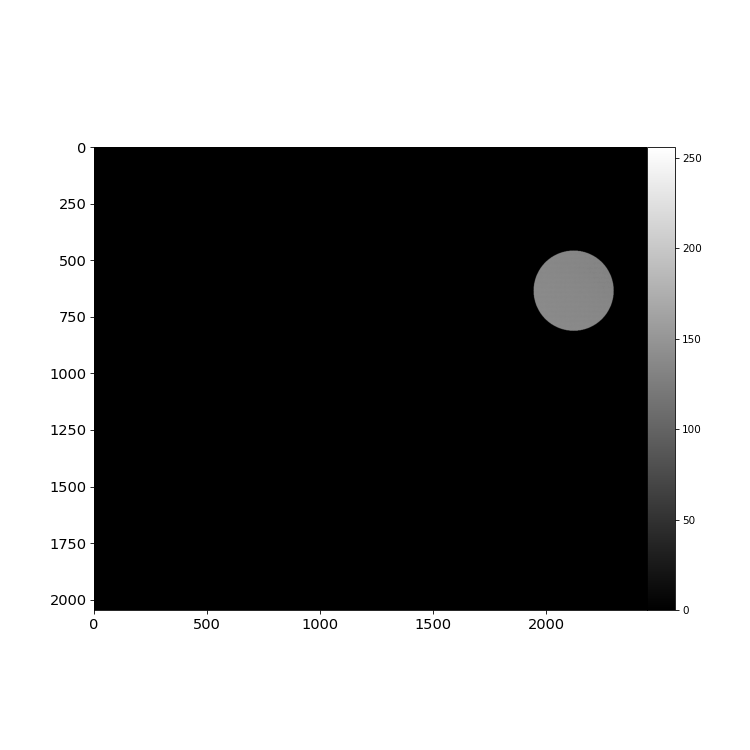

In [129]:
raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)
raw_images = np.squeeze(np.array(raw_images))
mean_image = np.mean(raw_images,axis=0)

im1_original = np.uint8(mean_image)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

im = ax.imshow(im1, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)
ax.tick_params(labelsize=14)


[[[1979.5  541.5  189.2]]]
[[[1979.5  541.5  189.2]]]


<IPython.core.display.Javascript object>


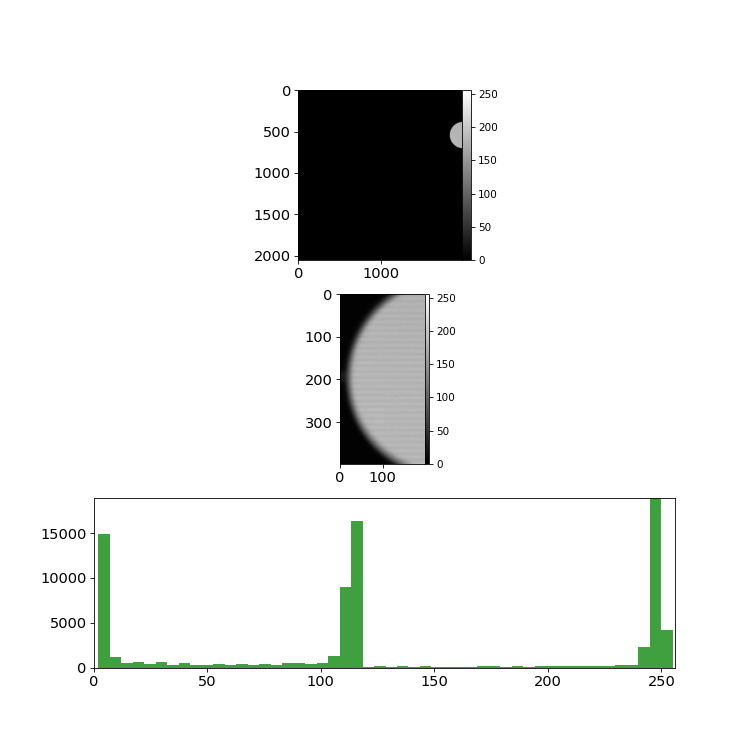

(0.0, 18975.0)

In [145]:
im1_original_ = im1_original[:,:1980]
croped_image, roi,_,_,_ = get_IS_port_circle_roi(im1_original_)
im1 = clear_circle_edges(im1_original_)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (10,10))
ax = ax.flatten()

im = ax[0].imshow(im1, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)
ax[0].tick_params(labelsize=14)

im = ax[1].imshow(croped_image, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)
ax[1].tick_params(labelsize=14)

# the histogram of the data
n, bins, patches = ax[2].hist(croped_image.flatten(),50, facecolor='g', alpha=0.75)
ax[2].tick_params(labelsize=14)
ax[2].set_xlim([0,2**8])
ax[2].set_ylim([0,np.max(n)])

# Image2

0 - 2021-12-02 20:09:32.079058 - 101936 captured Mono8 image 
1 - 2021-12-02 20:09:32.080084 - 101936 captured Mono8 image 
2 - 2021-12-02 20:09:32.224868 - 101936 captured Mono8 image 
3 - 2021-12-02 20:09:32.491493 - 101936 captured Mono8 image 
4 - 2021-12-02 20:09:32.595175 - 101936 captured Mono8 image 
5 - 2021-12-02 20:09:32.891774 - 101936 captured Mono8 image 
6 - 2021-12-02 20:09:33.118137 - 101936 captured Mono8 image 
7 - 2021-12-02 20:09:33.343547 - 101936 captured Mono8 image 
8 - 2021-12-02 20:09:33.468650 - 101936 captured Mono8 image 
9 - 2021-12-02 20:09:33.710845 - 101936 captured Mono8 image 
10 - 2021-12-02 20:09:33.780952 - 101936 captured Mono8 image 
11 - 2021-12-02 20:09:34.048235 - 101936 captured Mono8 image 
12 - 2021-12-02 20:09:34.460344 - 101936 captured Mono8 image 
13 - 2021-12-02 20:09:34.463334 - 101936 captured Mono8 image 
14 - 2021-12-02 20:09:34.721673 - 101936 captured Mono8 image 
15 - 2021-12-02 20:09:35.007225 - 101936 captured Mono8 image 
16

<IPython.core.display.Javascript object>


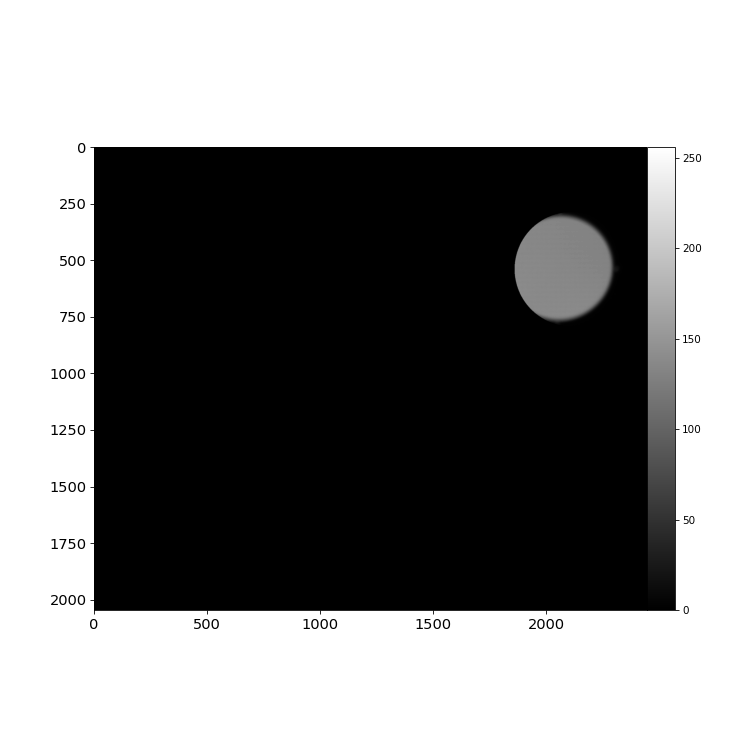

In [131]:
raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)
raw_images = np.squeeze(np.array(raw_images))
mean_image = np.mean(raw_images,axis=0)

im2_original = np.uint8(mean_image)

croped_image, roi,_,_,_ = get_IS_port_circle_roi(im2_original)
im2 = clear_circle_edges(im2_original)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

im = ax.imshow(im2, cmap=plt.get_cmap('gray'), vmin=0, vmax=256)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)
ax.tick_params(labelsize=14)


<IPython.core.display.Javascript object>


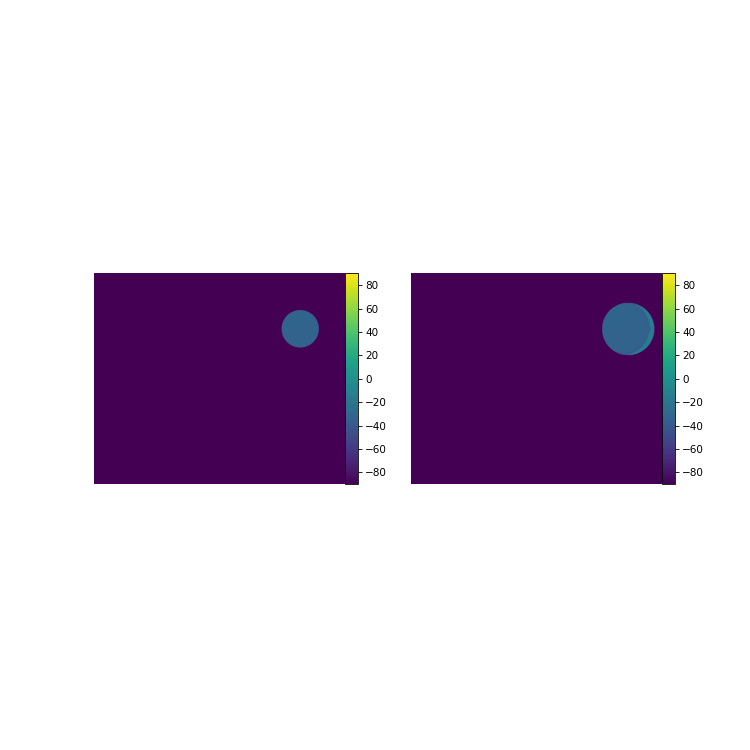

In [132]:
img_demosaiced_1 = pa.demosaicing(im1)
img_0_1, img_45_1, img_90_1, img_135_1 = cv2.split(img_demosaiced_1)
Stokes_1 =  pa.calcLinearStokes(np.moveaxis(np.array([img_0_1, img_45_1, img_90_1, img_135_1]), 0, -1),
                              np.deg2rad([0,45,90,135]))

AoLP_1 = ((180/np.pi)*pa.cvtStokesToAoLP(Stokes_1))-90

# 2:
img_demosaiced_2 = pa.demosaicing(im2)
img_0_2, img_45_2, img_90_2, img_135_2 = cv2.split(img_demosaiced_2)
Stokes_2 =  pa.calcLinearStokes(np.moveaxis(np.array([img_0_2, img_45_2, img_90_2, img_135_2]), 0, -1),
                              np.deg2rad([0,45,90,135]))

AoLP_2 = ((180/np.pi)*pa.cvtStokesToAoLP(Stokes_2))-90


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,10))

im = ax[0].imshow(AoLP_1, vmin=-90, vmax=90)
ax[0].axis('off')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)

im = ax[1].imshow(AoLP_2, vmin=-90, vmax=90)
ax[1].axis('off')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)


<IPython.core.display.Javascript object>


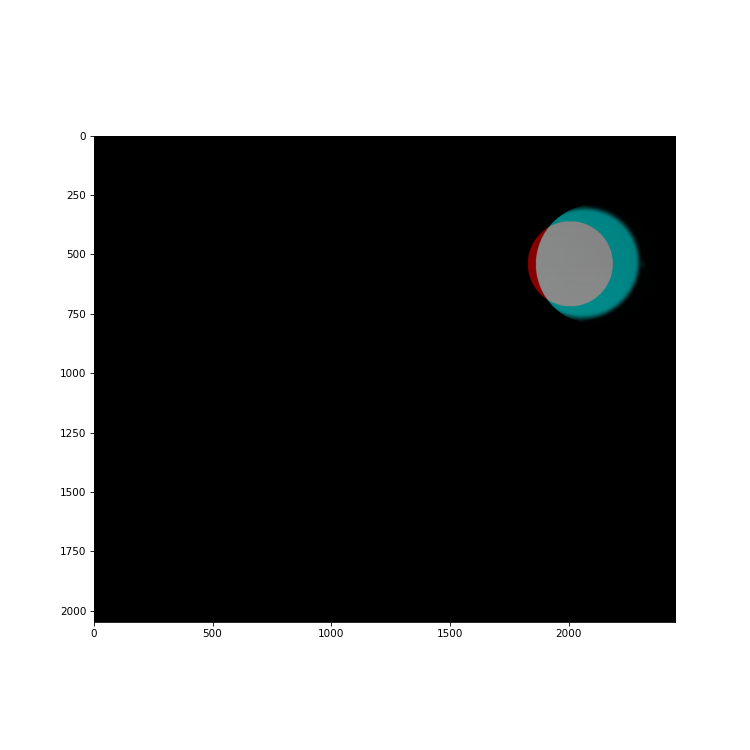

In [133]:
fig = plt.figure(figsize=(10, 10))
C = np.dstack((im1,im2,im2))
plt.imshow(C, vmin=0, vmax=256)



<IPython.core.display.Javascript object>


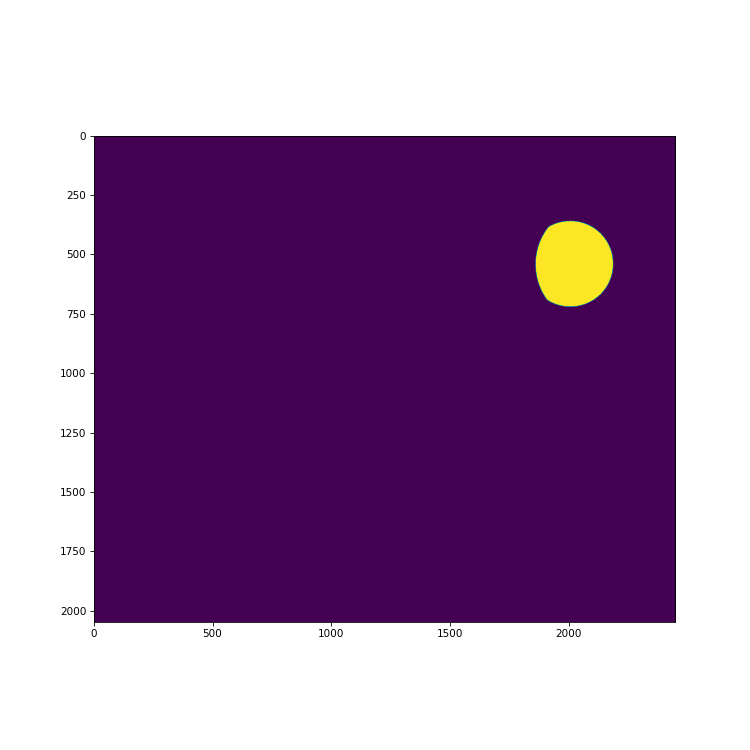

In [134]:
fig = plt.figure(figsize=(10, 10))
C = (AoLP_2>-89) * (AoLP_1>-89)
plt.imshow(C, vmin=0, vmax=1)

<IPython.core.display.Javascript object>


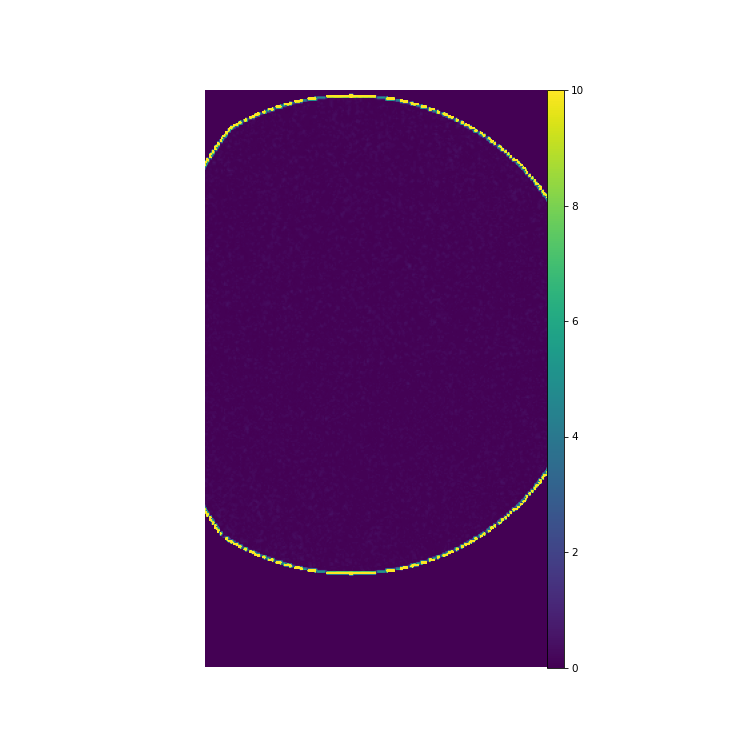

max
122.8385788019362
min
0.0
mean
0.710023885527949


In [135]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))
A = np.abs((AoLP_1 - AoLP_2)*C)
im = ax.imshow(A,vmin = 0,vmax = 10)
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)

print('max')
print(np.max(A))

print('min')
print(np.min(A))

print('mean')
print(np.mean(np.abs(AoLP_1[C] - AoLP_2[C])))

<IPython.core.display.Javascript object>


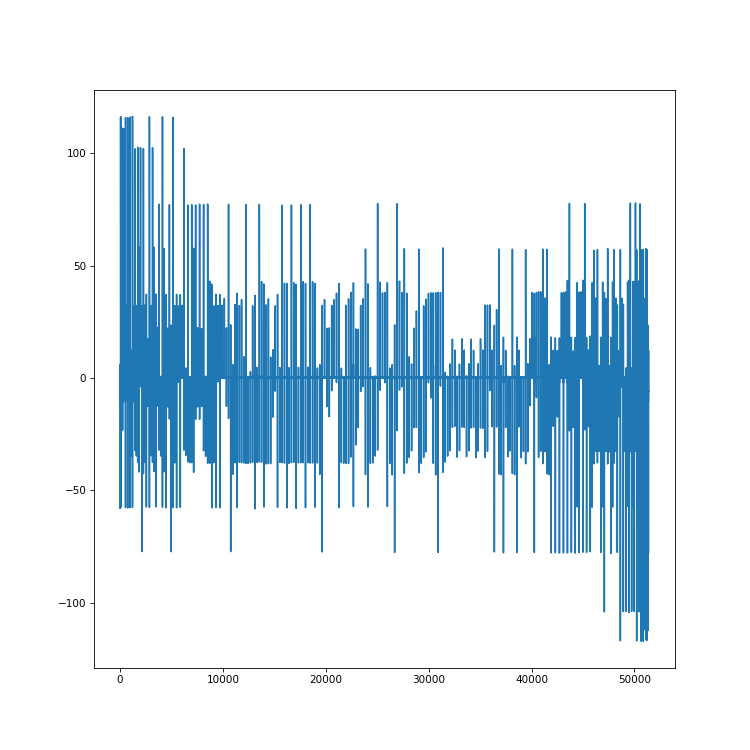

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

plt.plot(AoLP_1[C] - AoLP_2[C])

In [108]:
AoLP_1.min()

-90.0

In [126]:
C


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])